In [121]:
import neptune.new as neptune
from utils import *
import numpy as np


import ipywidgets as ipw
from ipywidgets.embed import embed_minimal_html

import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
from tqdm import tqdm

def figures_to_html(figs, filename="dashboard.html"):
    dashboard = open(filename, 'w')
    dashboard.write("<html><head></head><body>" + "\n")
    for fig in figs:
        inner_html = fig.to_html().split('<body>')[1].split('</body>')[0]
        dashboard.write(inner_html)
    dashboard.write("</body></html>" + "\n")

In [122]:
project = neptune.get_project(
    name='rahatzamancse/MPSE-mds', 
    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3NDk5MWVkNS0wMDg4LTRmNTktYWQyZC0zNzUyNTg0MTY1MGYifQ=='
)

# Get dashboard with runs contributed by 'sophia' tagged 'cycleLR'
run_table_df = project.fetch_runs_table(
    owner='rahatzamancse',
).to_pandas()

run_table_df.columns

Index(['sys/creation_time', 'sys/description', 'sys/failed', 'sys/hostname',
       'sys/id', 'sys/modification_time', 'sys/monitoring_time', 'sys/name',
       'sys/owner', 'sys/ping_time', 'sys/running_time', 'sys/size',
       'sys/state', 'sys/tags', 'GT/Points per perspective list',
       'Results/Alignment/4PointSample/error',
       'Results/Alignment/4Point_ICP/error',
       'Results/Alignment/Global-RMSE-opt/error',
       'Results/Alignment/GlobalRMSE_ICP/error', 'Results/Final Cost',
       'Results/Final Individual Cost',
       'Results/computation history/Actual Iterations Run',
       'Results/computation history/Conclusion',
       'Results/computation history/costs',
       'Results/computation history/grads', 'Results/computation history/lrs',
       'Results/computation history/steps', 'parameters/DATASET',
       'parameters/INITIAL_EMBEDDING', 'parameters/MPSE/BATCH_SIZE',
       'parameters/MPSE/INITIAL_PROJECTIONS', 'parameters/MPSE/MAX_ITER',
       'parameter

In [123]:
plot_df = run_table_df[
    run_table_df['parameters/PROJECTION/PROJ_TYPE'] == 'atleast_in_n_persp'
][[
    'Results/Alignment/4PointSample/error',
    'Results/Alignment/4Point_ICP/error',
    'Results/Alignment/Global-RMSE-opt/error',
    'Results/Alignment/GlobalRMSE_ICP/error',
    'Results/Final Cost',
    'parameters/DATASET',
    'parameters/N_PERSPECTIVE',
    'parameters/PROJECTION/POINT_IN_ATLEAST',
    'parameters/N_POINTS',
    'parameters/MPSE/SMART_INITIALIZATION',
    'parameters/MPSE/VARIABLE_PROJECTION',
    'sys/id'
]]

plot_df.columns = [
    '4_point_error',
    '4_point_icp_error',
    'rmse_error',
    'rmse_ICP_error',
    'mpse_error',
    'dataset',
    '# perspectives',
    'points in exactly # perspectives',
    '#points',
    'smart_init',
    'variable projection',
    'exp_id'
]

plot_df = plot_df.dropna(axis=0)
plot_df['perspective_percentage'] = plot_df['points in exactly # perspectives'] / plot_df['# perspectives']

plot_df.head()

,4_point_error,4_point_icp_error,rmse_error,rmse_ICP_error,mpse_error,dataset,# perspectives,points in exactly # perspectives,#points,smart_init,variable projection,exp_id,perspective_percentage
1,0.567874,0.567904,0.566253,0.566928,0.850824,ModelNet10:chair:0001,14.0,3.0,512.0,False,False,MPSEMDS-1724,0.214286
2,0.827217,0.827811,0.823014,0.825001,0.883937,ModelNet10:chair:0001,14.0,3.0,512.0,False,True,MPSEMDS-1723,0.214286
3,8.461002,8.631755,8.117806,8.492164,1.529302,ModelNet10:chair:0001,14.0,2.0,512.0,False,False,MPSEMDS-1722,0.142857
4,7.950462,8.034022,7.899365,8.350447,1.916973,ModelNet10:chair:0001,14.0,2.0,512.0,False,True,MPSEMDS-1721,0.142857
5,17.020468,17.002350,14.315884,29.215416,2.196524,ModelNet10:chair:0001,14.0,1.0,512.0,False,False,MPSEMDS-1720,0.071429


In [124]:
def plot_loss(df, x = 'points in exactly # perspectives', y = 'rmse_error', title=None, plot_area=True, clip_val=20):
    
    df[y] = df[y].apply(lambda x: clip_val if x > clip_val else x)

    agg_col_dict = {}

    agg_fns = ['mean', 'min', 'max', 'median', 'count']
    for agg_fn in agg_fns:
        agg_col_dict[f'{y}_{agg_fn}'] = (y, agg_fn)
    df['exp_id_error'] = f'<a href="https://app.neptune.ai/rahatzamancse/MPSE-mds/e/{df["exp_id"].astype(str)}/all">' + df['exp_id'].astype(str) + '</a> (' + df[y].round(2).astype(str) + ')<br>'
    agg_col_dict['exp_ids'] = ('exp_id_error', lambda x: ' '.join(x))
    
    
    aggregated_plot_df = df.groupby(['dataset', x]).agg(**agg_col_dict).reset_index()
    
    melted_viz_df = aggregated_plot_df.melt(id_vars = ['dataset', x])
    melted_viz_df = melted_viz_df.sort_values([x, 'dataset', 'variable', 'value'])
    
    color_palette = [[int(color.strip('#')[i:i+2], 16) for i in (0, 2, 4)] for color in px.colors.qualitative.Plotly]
    
    fig = make_subplots(
        rows=2, cols=1,
        row_heights=[0.8, 0.2],
        vertical_spacing = 0.02,
        shared_yaxes=False,
        shared_xaxes=True,
    )
    
    for i, dataset in enumerate(melted_viz_df['dataset'].unique()):
        
        single_dataset_melted_df = melted_viz_df[melted_viz_df['dataset'] == dataset]
        
        X = [round(elem, 2) for elem in (single_dataset_melted_df[single_dataset_melted_df['variable'] == f'{y}_mean'])[x].tolist()]
        Y_mean = [round(elem, 2) for elem in (single_dataset_melted_df[single_dataset_melted_df['variable'] == f'{y}_mean'])["value"].tolist()]
        Y_upper = [round(elem, 2) for elem in (single_dataset_melted_df[single_dataset_melted_df['variable'] == f'{y}_max'])["value"].tolist()]
        Y_lower = [round(elem, 2) for elem in (single_dataset_melted_df[single_dataset_melted_df['variable'] == f'{y}_min'])["value"].tolist()][::-1]
        Y_median = [round(elem, 2) for elem in (single_dataset_melted_df[single_dataset_melted_df['variable'] == f'{y}_median'])["value"].tolist()]
        
        for idx, (y_up, y_lo) in enumerate(zip(Y_upper, Y_lower)):
            if y_up <= y_lo:
                Y_lower[idx] -= y_up - 0.1

        X_rev = X[::-1]
        
        color = color_palette[i % len(color_palette)]
        line_color = 'rgb('+','.join(str(c) for c in color)+')'
        area_color = 'rgba('+','.join(str(min(max(c,0), 255)) for c in color)+',0.2)'
        median_color = 'rgba('+','.join(str(min(max(c + 20,0), 255)) for c in color)+',0.8)'
        
        if plot_area:
            fig.add_trace(go.Scatter(
                x=X+X_rev,
                y=Y_upper+Y_lower,
                fill='toself',
                fillcolor=area_color,
                line_color=area_color,
                showlegend=False,
                name=f'{dataset}',
                legendgroup=f'{dataset}',
                hoverinfo='none',
            ), row=1, col=1)
        
        fig.add_trace(go.Scatter(
            x=X, y=Y_mean,
            line_color=line_color,
            name=dataset,
            showlegend=True,
            legendgroup=f'{dataset}',
            connectgaps=True,
            hovertemplate = y + ': %{y:.2f}<br>%{text} <extra></extra>',
            text=['Number of experiments done : ' + str(int(row1['value'])) + '<br><b>Experiment IDs</b> : <br>' + (row2['value'])
                  for (i1, row1),(i2,row2) in zip(
                      single_dataset_melted_df[single_dataset_melted_df['variable'] == f'{y}_count'].iterrows(),
                      single_dataset_melted_df[single_dataset_melted_df['variable'] == f'exp_ids'].iterrows(),

                  )],
            hoverinfo='none'
        ), row=1, col=1)
        fig.add_trace(go.Scatter(
            x=X, y=Y_median,
            name=f'{dataset}',
            line = dict(color=median_color, dash='dash'),
            showlegend=False,
            legendgroup=f'{dataset}',
            connectgaps=True,
            hoverinfo='none',
        ), row=1, col=1)
        
        fig.add_trace(
            go.Bar(
                x=X,
                y=single_dataset_melted_df[single_dataset_melted_df['variable'] == f'{y}_count']['value'],
                hoverinfo='none',
                marker_color=line_color,
                showlegend=False,
                legendgroup=f'{dataset}',
            ),
            row=2, col=1
        )
        
    fig.update_layout(
        title=title if title else y,
        xaxis_title=x,
        yaxis_title=y,
        legend_title="Datasets",
        hovermode="x unified",
        barmode='group',
        # layout_yaxis_range=[0,clip_val+5]
    )
    fig.update_layout(yaxis1 = dict(range=[0,clip_val+5]))

    return fig


/var/folders/wy/q0qj8jz103qgqr7k37xqjxwc0000ks/T/ipykernel_3122/2822141670.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/wy/q0qj8jz103qgqr7k37xqjxwc0000ks/T/ipykernel_3122/2822141670.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



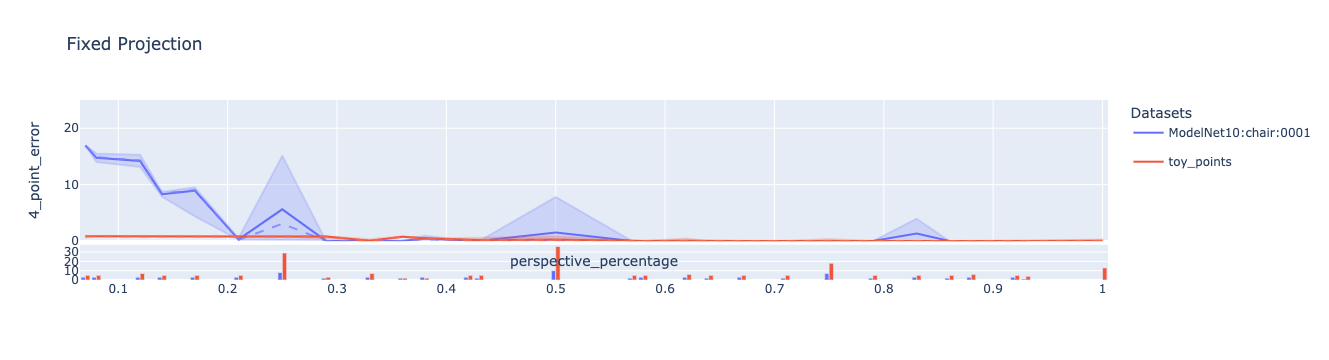

In [126]:
plot_loss(
        plot_df[plot_df['variable projection'] == False],
        y = '4_point_error',
        x = 'perspective_percentage',
        title = "Fixed Projection",
    )

In [127]:
figs = [
    plot_loss(
        plot_df[plot_df['variable projection'] == False],
        y = '4_point_error',
        x = 'perspective_percentage',
        title = "Fixed Projection",
    ),
    plot_loss(
        plot_df[plot_df['variable projection'] == False],
        y = 'mpse_error',
        x = 'perspective_percentage',
        title = "Fixed Projection",
    ),
    plot_loss(
        plot_df[plot_df['variable projection'] == False],
        y = 'rmse_error',
        x = 'perspective_percentage',
        title = "Fixed Projection",
    ),
    plot_loss(
        plot_df[plot_df['variable projection'] == False],
        y = '4_point_icp_error',
        x = 'perspective_percentage',
        title = "Fixed Projection",
    ),
    plot_loss(
        plot_df[plot_df['variable projection'] == False],
        y = 'rmse_ICP_error',
        x = 'perspective_percentage',
        title = "Fixed Projection",
    ),
    plot_loss(
        plot_df[plot_df['variable projection'] == True],
        y = '4_point_error',
        x = 'perspective_percentage',
        title = "Variable Projection",
    ),
    plot_loss(
        plot_df[plot_df['variable projection'] == True],
        y = 'mpse_error',
        x = 'perspective_percentage',
        title = "Variable Projection",
    ),
    plot_loss(
        plot_df[plot_df['variable projection'] == True],
        y = 'rmse_error',
        x = 'perspective_percentage',
        title = "Variable Projection",
    ),
    plot_loss(
        plot_df[plot_df['variable projection'] == True],
        y = '4_point_icp_error',
        x = 'perspective_percentage',
        title = "Variable Projection",
    ),
    plot_loss(
        plot_df[plot_df['variable projection'] == True],
        y = 'rmse_ICP_error',
        x = 'perspective_percentage',
        title = "Variable Projection",
    ),
]


# figures_to_html(figs)

final_fig = ipw.VBox([
    ipw.VBox([
        go.FigureWidget(figs[1]),
        ipw.VBox([
            ipw.HBox([go.FigureWidget(figs[2]), go.FigureWidget(figs[4])]),
            ipw.HBox([go.FigureWidget(figs[0]), go.FigureWidget(figs[3])]),
        ]),
        go.FigureWidget(figs[1+5]),
        ipw.VBox([
            ipw.HBox([go.FigureWidget(figs[2+5]), go.FigureWidget(figs[4+5])]),
            ipw.HBox([go.FigureWidget(figs[0+5]), go.FigureWidget(figs[3+5])]),
        ]),
    ])
])

embed_minimal_html('summary/point_persp_percentage.html', views=[final_fig], title='Widgets export')

final_fig

/var/folders/wy/q0qj8jz103qgqr7k37xqjxwc0000ks/T/ipykernel_3122/2822141670.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/wy/q0qj8jz103qgqr7k37xqjxwc0000ks/T/ipykernel_3122/2822141670.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



    'data': [{'fill': 'toself',
              'fillcolor': 'rgba(…

In [134]:
n_persp = 4

figs = [
    plot_loss(
        plot_df[(plot_df['variable projection'] == False) & (plot_df['# perspectives'] == n_persp)],
        y = '4_point_error',
        x = 'points in exactly # perspectives',
        title = "Fixed Projection",
    ),
    plot_loss(
        plot_df[(plot_df['variable projection'] == False) & (plot_df['# perspectives'] == n_persp)],
        y = 'mpse_error',
        x = 'points in exactly # perspectives',
        title = "Fixed Projection",
    ),
    plot_loss(
        plot_df[(plot_df['variable projection'] == False) & (plot_df['# perspectives'] == n_persp)],
        y = 'rmse_error',
        x = 'points in exactly # perspectives',
        title = "Fixed Projection",
    ),
    plot_loss(
        plot_df[(plot_df['variable projection'] == False) & (plot_df['# perspectives'] == n_persp)],
        y = '4_point_icp_error',
        x = 'points in exactly # perspectives',
        title = "Fixed Projection",
    ),
    plot_loss(
        plot_df[(plot_df['variable projection'] == False) & (plot_df['# perspectives'] == n_persp)],
        y = 'rmse_ICP_error',
        x = 'points in exactly # perspectives',
        title = "Fixed Projection",
    ),
    plot_loss(
        plot_df[(plot_df['variable projection'] == True) & (plot_df['# perspectives'] == n_persp)],
        y = '4_point_error',
        x = 'points in exactly # perspectives',
        title = "Variable Projection",
    ),
    plot_loss(
        plot_df[(plot_df['variable projection'] == True) & (plot_df['# perspectives'] == n_persp)],
        y = 'mpse_error',
        x = 'points in exactly # perspectives',
        title = "Variable Projection",
    ),
    plot_loss(
        plot_df[(plot_df['variable projection'] == True) & (plot_df['# perspectives'] == n_persp)],
        y = 'rmse_error',
        x = 'points in exactly # perspectives',
        title = "Variable Projection",
    ),
    plot_loss(
        plot_df[(plot_df['variable projection'] == True) & (plot_df['# perspectives'] == n_persp)],
        y = '4_point_icp_error',
        x = 'points in exactly # perspectives',
        title = "Variable Projection",
    ),
    plot_loss(
        plot_df[(plot_df['variable projection'] == True) & (plot_df['# perspectives'] == n_persp)],
        y = 'rmse_ICP_error',
        x = 'points in exactly # perspectives',
        title = "Variable Projection",
    ),
]


# figures_to_html(figs)

final_fig = ipw.VBox([
    ipw.VBox([
        go.FigureWidget(figs[1]),
        ipw.VBox([
            ipw.HBox([go.FigureWidget(figs[2]), go.FigureWidget(figs[4])]),
            ipw.HBox([go.FigureWidget(figs[0]), go.FigureWidget(figs[3])]),
        ]),
        go.FigureWidget(figs[1+5]),
        ipw.VBox([
            ipw.HBox([go.FigureWidget(figs[2+5]), go.FigureWidget(figs[4+5])]),
            ipw.HBox([go.FigureWidget(figs[0+5]), go.FigureWidget(figs[3+5])]),
        ]),
    ])
])

embed_minimal_html(f'summary/{n_persp}_persp.html', views=[final_fig], title='Widgets export')

final_fig

/var/folders/wy/q0qj8jz103qgqr7k37xqjxwc0000ks/T/ipykernel_3122/2822141670.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/wy/q0qj8jz103qgqr7k37xqjxwc0000ks/T/ipykernel_3122/2822141670.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



    'data': [{'fill': 'toself',
              'fillcolor': 'rgba(…

# To download by runs

In [ ]:
load_csv = 'experiment_metrics.csv'
USE_CSV = False

if USE_CSV:
    plot_df = pd.read_csv(load_csv)
else:
    plot_df = pd.DataFrame(columns=['run_id', 'stress', '4_sample_cost', 'RMSE_opt_cost', 'p_at_least_persp', 'total_perspective', 'dataset', 'RMSE_opt_ICP', '4Point_ICP'])
    for run_id in tqdm(run_table_df['sys/id']):
        run = neptune.init(
            project='rahatzamancse/MPSE-mds',
            api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3NDk5MWVkNS0wMDg4LTRmNTktYWQyZC0zNzUyNTg0MTY1MGYifQ==',
            run=run_id,
            mode="read-only"
        )

        plot_df = plot_df.append({
            'run_id': run_id,
            'stress': run[val].fetch() if run.exists((val := 'Results/Final Cost')) else None,
            '4_sample_cost': run[val].fetch() if run.exists((val := 'Results/Alignment/4PointSample/error')) else None,
            'RMSE_opt_cost': run[val].fetch() if run.exists((val := 'Results/Alignment/Global-RMSE-opt/error')) else None,
            'p_at_least_persp': run[val].fetch() if run.exists((val := 'parameters/PROJECTION/POINT_IN_ATLEAST')) else None,
            'total_perspective': run[val].fetch() if run.exists((val := 'parameters/N_PERSPECTIVE')) else None,
            'dataset': run[val].fetch() if run.exists((val := 'parameters/DATASET')) else None,
            '4Point_ICP': run[val].fetch() if run.exists((val := 'Results/Alignment/4Point_ICP/error')) else None,
            'RMSE_opt_ICP': run[val].fetch() if run.exists((val := 'Results/Alignment/GlobalRMSE_ICP/error')) else None,
        }, ignore_index=True)

        run.stop()
        
plot_df.to_csv('experiment_metrics.csv')